# Rainfall anomalies from Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS)

* **Products used:** 
[rainfall_chirps_monthly](https://explorer.digitalearth.africa/products/rainfall_chirps_monthly)

## Background

Rainfall anomalies are deviations of rainfall from long-run averages. They are useful for identifying wet and dry periods which can be linked to climatically influenced patterns such as flooding, river flows, and agricultural production.

## Description
In this real world example we will calculate rainfall anomalies for a selected African country using the CHIRPS monthly rainfall dataset. 
Standardised anomaly is calculated as:

\begin{equation}
\text{Standardised anomaly }=\frac{x-m}{s}
\end{equation}

**x** is the seasonal mean, **m** is the long-term mean, and **s** is the long-term standard deviation.

This means we need a long-term reference period (m) and a period of interest (x) for which we'll calculate the anomalies. This notebook names datasets `ds_rf_m` and `ds_rf_x` accordingly.  

The notebook outlines:

1. Loading a shapefile for African countries and selecting a single country
2. Loading and rainfall data and masking it to the selected country.
3. Calculating monthly rainfall anomalies and plotting the result, aggregated over space, as a bar chart.
4. Calculating and plotting monthly rainfall anomalies spatially.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datacube.utils.geometry import Geometry, CRS
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.plotting import display_map

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/melinda.boyers@glasgow.ac.uk/proxy/8787/status,
Dashboard: /user/melinda.boyers@glasgow.ac.uk/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 97.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38313,Workers: 1
Dashboard: /user/melinda.boyers@glasgow.ac.uk/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 97.21 GiB
Comm: tcp://127.0.0.1:46053,Total threads: 15
Dashboard: /user/melinda.boyers@glasgow.ac.uk/proxy/35263/status,Memory: 97.21 GiB
Nanny: tcp://127.0.0.1:41361,


### Analysis parameters

The following cell sets important parameters for the analysis:

* `country`: In this analysis, we'll select an African country to mask the dataset and analysis.
* `time_m`: CHIRPS monthly rainfall is available from 1981. The long-term mean for rainfall anomalies is often calculated on a 30-year period, so we'll use 1981 to 2011 in this example.
* `time_x`: This is the period for which we want to calculate anomalies.
* `resolution`: We'll use 5,000 m, which is approximately equal to the default resolution shown above.
* `dask_chunks`:  the size of the dask chunks, dask breaks data into manageable chunks that can be easily stored in memory, e.g. dict(x=1000,y=1000)

Standardised anomaly is calculated as:

\begin{equation}
\text{Standardised anomaly }=\frac{x-m}{s}
\end{equation}

$x$ is the seasonal mean, $m$ is the long-term mean, and $s$ is the long-term standard deviation.

This means we need a long-term reference period (m) and a period of interest (x) for which we'll calculate the anomalies. This notebook names datasets `ds_rf_m` and `ds_rf_x` accordingly.  

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.


In [3]:
# Select a country, for the example we will use Kenya, a complete list of countries is available below.
country = "Tanzania"

# Set the range of dates for the climatology, this will be the reference period (m) for the anomaly calculation.
# Standard practice is to use a 30 year period, so we've used 1981 to 2011 in this example.
time_m = ('1981', '2011')

# time period for monthly anomaly (x)
time_x = ('1990', '2023')

# CHIRPS has a spatial resolution of ~5x5 km
resolution = (-5000, 5000)

#size of dask chunks
dask_chunks = dict(x=500,y=500)

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app='rainfall_anomaly')

### Load the African Countries shapefile

This shapefile contains polygons for the boundaries of African countries and will allows us to calculate rainfall anomalies within a chosen country

In [5]:
#african_countries = gpd.read_file('../Supplementary_data/Rainfall_anomaly_CHIRPS/african_countries.geojson')
serengeti = gpd.read_file('data/serengeti.geojson')
serengeti.explore()
#print(gdf)

In [6]:
idx = serengeti[serengeti['ID'] == 0].index[0]
geom = Geometry(geom=serengeti.iloc[idx].geometry, crs=serengeti.crs)
#geom = Geometry(geom=gdf.geometry, crs=gdf.crs)

## Load rainfall data

First, let's have a look at the product information for CHIRPS rainfall. We can see that it is stored in monthly timestamps and its native resolution is approximately 0.05 degrees.

In [7]:
dc.list_products().loc[dc.list_products()['name'].str.contains('chirps')]

,name,description,license,default_crs,default_resolution
name,,,,,
rainfall_chirps_daily,rainfall_chirps_daily,Rainfall Estimates from Rain Gauge and Satelli...,None,None,None
rainfall_chirps_monthly,rainfall_chirps_monthly,Rainfall Estimates from Rain Gauge and Satelli...,None,None,None


### Load data for long-term climatology (m)

Using the analysis parameters defined above, we will load CHIRPS monthly rainfall data for the 30-year reference period (m).


In [8]:
query = {#'x': lon_range,
        #'y': lat_range,
    'geopolygon' : geom,
         'time': ('2015', '2023'),
         'output_crs': 'epsg:21036',
         'resolution': (-5000,5000),
         'measurements': ['rainfall'],
         'dask_chunks':dask_chunks
        }

ds_rf = dc.load(product='rainfall_chirps_daily', **query)
ds_rf

<xarray.Dataset>
Dimensions:      (time: 3165, y: 103, x: 88)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01T11:59:59.500000 ... 2023-09...
  * y            (y) float64 9.992e+06 9.988e+06 ... 9.488e+06 9.482e+06
  * x            (x) float64 4.925e+05 4.975e+05 ... 9.225e+05 9.275e+05
    spatial_ref  int32 21036
Data variables:
    rainfall     (time, y, x) float32 dask.array<chunksize=(1, 103, 88), meta=np.ndarray>
Attributes:
    crs:           epsg:21036
    grid_mapping:  spatial_ref

In [11]:
# Remove the 'units' key from the 'time' variable's attributes
ds_rf['time'].attrs.pop('units', None)

# Save the dataset to NetCDF
ds_rf.to_netcdf("serengeti_chirps.nc")

/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


## Mask the rainfall dataset using the country boundary

Below, the country polygon is rasterized so the rainfall dataset is masked within that raster.

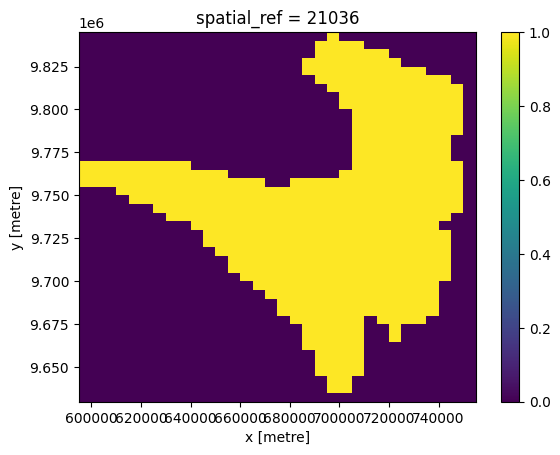

In [11]:
serengeti = serengeti.to_crs('epsg:21036')

mask = xr_rasterize(serengeti[serengeti['ID'] == 0], ds_rf)

#mask the rainfall dataset
ds_rf = ds_rf.where(mask)

# Plot the mask
mask.plot()

## Calculate monthly rainfall climatology

We want to capture both the monthly mean (i.e. each month averaged over thirty years) and the monthly standard deviation of rainfall within the country polygon for each year from 1981 to 2011. Firstly, rainfall is grouped by month and a mean is calculated, then the standard devation in rainfall total for each month is calculated

In [12]:
ds_rf_m = ds_rf.where(ds_rf !=-9999.) #convert missing values to NaN

# monthly means
climatology_mean = ds_rf_m.groupby('time.month').mean('time').compute()

#calculate monthly std dev
climatology_std = ds_rf_m.groupby('time.month').std('time').compute()


Now we can plot the rainfall mean climatology, this is the average rainfall (over 30 years) for each month

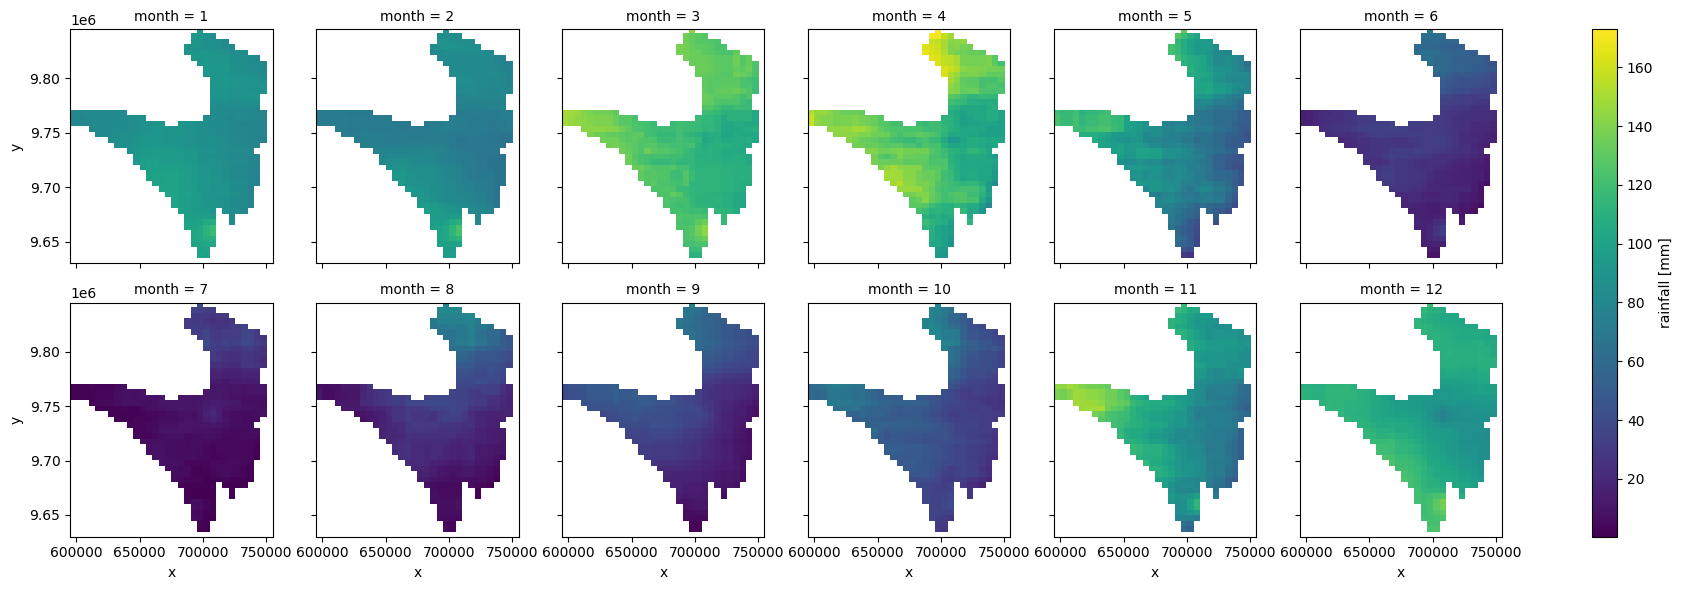

In [13]:
climatology_mean['rainfall'].plot.imshow(cmap='viridis', col='month', col_wrap=6, label=False);

## Load data for the anomaly period

Using the analysis parameters defined above, we will load CHIRPS rainfall data for the period over which we want to calculate anomalies (x). We also need to mask this dataset to the country polygon.

In [14]:
#load rainfall data for the anomaly period matching the spatial extent of the climatologies
ds_rf_x = dc.load(product='rainfall_chirps_monthly',
                  like=ds_rf.geobox,
                  time=time_x,
                  dask_chunks=dask_chunks)

#mask with country polygon
ds_rf_x=ds_rf_x.where(mask)

## Calculate standardised anomalies

We can visualise the anomalies spatially and see if they are associated with certain landscape features.

Do the spatial anomalies shown in the plots below align with the aggregated anomalies shown above?

In [15]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds_rf_x.groupby("time.month"),
    climatology_mean,
    climatology_std,
    output_dtypes=[ds_rf_x.rainfall.dtype],
    dask="allowed"
).compute()

## Plot average rainfall anomalies across the country

Below, the spatial mean is taken so we can present the monthly anomalies aggregated across the selected country.

In [16]:
spatial_mean_anoms = stand_anomalies.rainfall.mean(['x','y']).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

Below, we plot a bar graph that will show the average rainfall anomaly across the country

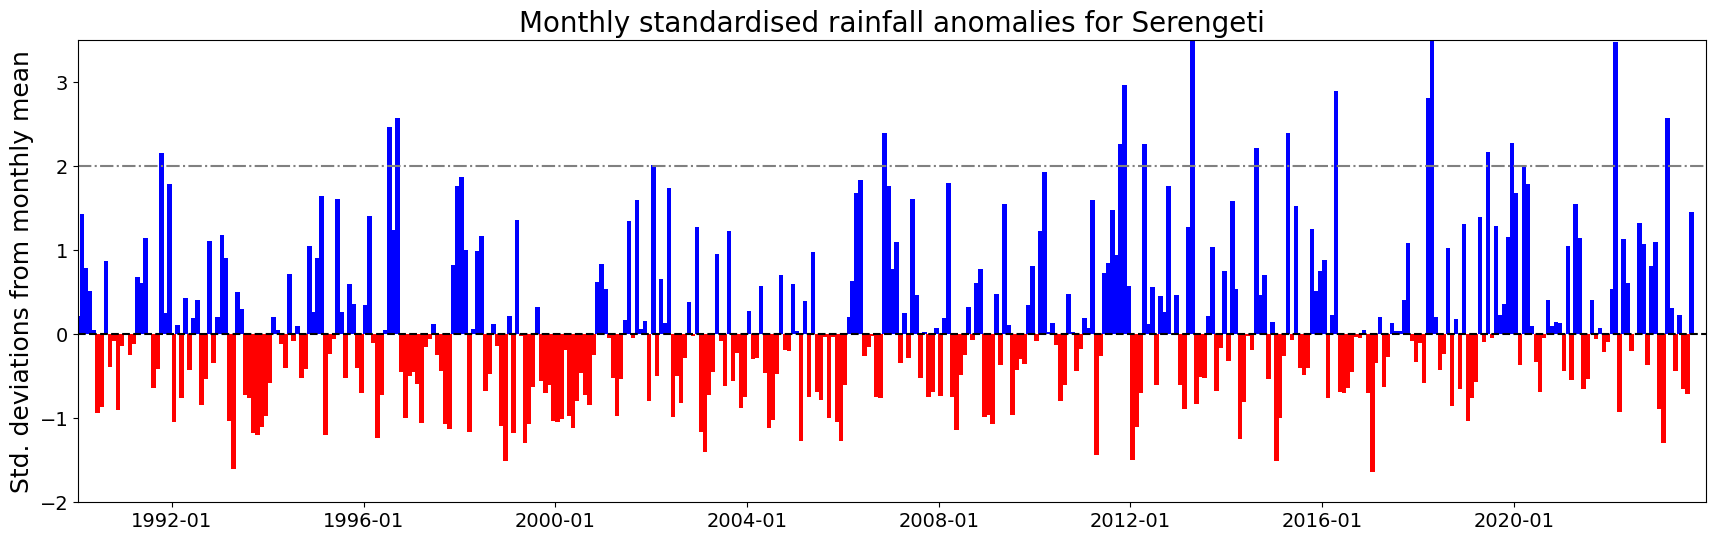

In [17]:
fig, ax = plt.subplots(figsize=(21,6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_ylim(-2,3.5)
ax.bar(spatial_mean_anoms.index,
       spatial_mean_anoms.rainfall,
       width=35, align='center',
       color=(spatial_mean_anoms['rainfall'] > 0).map({True: 'b', False: 'r'}))
ax.axhline(0, color='black', linestyle='--')
ax.axhline(2, color='grey', linestyle='-.')
plt.title('Monthly standardised rainfall anomalies for Serengeti', fontsize=20)
plt.ylabel('Std. deviations from monthly mean', fontsize=18)
# Limit the x-axis to the end of data (year 2023)
end_date = pd.to_datetime('2023-12-31')
plt.xlim(spatial_mean_anoms.index[0], end_date)
# Increase x-axis font size
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14);

## Per-pixel plots of rainfall anomalies

Average anomalies across the entire country obscure details on how rainfall anomalies are spatially distrbuted within the country. Below, enter a `start` and `end` date (in format `'YYYY-MM'`) that is within the `time_x` range you entered in the `Analysis parameters` section to plot per-pixel anomalies for the range of dates you specify.

In [ ]:
#Select a time-range to plot
start='2020-07'
end='2021-06' 

### Plot the per-pixel anomalies

In [ ]:
stand_anomalies['rainfall'].sel(time=slice(start,end)).plot(cmap='RdBu', label=False, col="time", col_wrap=6, robust=True);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')